In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt

# Module for Google Drive
from google.colab import drive

# Module for Importing Images
from PIL import Image 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
drive.mount('/content/drive')
%cd './drive/MyDrive/vgg16'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: './drive/MyDrive/vgg16'
/content/drive/MyDrive/vgg16


In [ ]:
data_path = 'dataset'
model_dir = 'models'  

In [ ]:
class XayDataset(Dataset):
    def __init__(self, data_path, is_training):
        self.data_path = data_path
        self.train_path = os.path.join(data_path, 'train')
        self.val_path = os.path.join(data_path, 'val')
        self.is_training = is_training
        if self.is_training:
            self.target_path = self.train_path
        else:
            self.target_path = self.val_path
        self.img_list = os.listdir(self.target_path)
            
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
        self.random_crop = torchvision.transforms.RandomCrop(size = 170)
        self.random_flip = torchvision.transforms.RandomHorizontalFlip(p=0.5)
        self.resize = torchvision.transforms.Resize(size=(224,224))
        self.train_transform = torchvision.transforms.Compose([self.tensor_transform,self.random_flip,
                                                         self.resize,
                                                         self.normalize_transform])
        self.validate_transform = torchvision.transforms.Compose([self.tensor_transform, self.resize,
                                                                  self.normalize_transform])

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        fp= os.path.join(self.target_path,self.img_list[idx])
        img = Image.open(fp)
        class_name=self.img_list[idx].split(".")[1]
        class_to_idx = {"Gun": 0, "Knife": 1, "Wrench": 2}
        label=class_to_idx[class_name]
        original_img = self.tensor_transform(img)

        if self.is_training:
            input = self.train_transform(img)
        else:
            input = self.validate_transform(img)
            
        sample = dict()
        sample['input'] = input
        sample['target'] = label
        sample['class_name'] = class_name

        return sample

In [ ]:
batch_size = 16

train_dataset = XayDataset(data_path, True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataset = XayDataset(data_path, False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


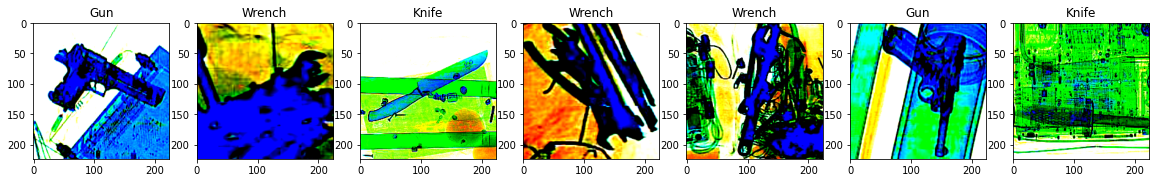

In [ ]:
sample = next(iter(train_dataloader))
fig, ax = plt.subplots(1, 7, figsize=(20, 10))
for i in range(7):
    ax[i].imshow(sample['input'][i].permute(1, 2, 0))
    ax[i].set_title(sample['class_name'][i])

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


In [ ]:
class VGG_16(nn.Module):
    def __init__(self, num_class=3):
        super(VGG_16, self).__init__()

       
        self.net = torchvision.models.vgg16(pretrained=False)
        self.net.classifier[6] = nn.Linear(in_features=4096, out_features=num_class, bias=True)
    def forward(self, img):
       
        out = self.net(img) 
   
        return out

In [ ]:
model = VGG_16()

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0005)


In [ ]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    input = sample['input'].float().to(device)
    target = sample['target'].long().to(device) 
    
    pred = model(input)
    pred_loss = criterion(pred, target)

   
    y_pred = pred.argmax(1)
    num_true=torch.sum(((y_pred-target)==0))

    
    pred_loss.backward()
       
    optimizer.step()
    return pred_loss.item(),num_true



In [ ]:
def validate(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)
        pred_loss = criterion(pred, target)

        y_pred = pred.argmax(1)
        num_true=torch.sum(((y_pred-target)==0))
        
    return pred_loss.item(),num_true

In [ ]:
max_epoch = 50
save_stride = 10
tmp_path =  './checkpoint.pth'
max_accu=0
for epoch in range(max_epoch):        
  
    train_loss = 0.0

  
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
     
    print()
    print("--------------epoch {}-----------------".format(epoch))
    train_true=0
    for idx, sample in enumerate(train_dataloader):
            curr_loss,num_true = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dataloader)
            train_true+=num_true
    print("train_loss: ", train_loss)
    print("train_acc: ",train_true/len(train_dataset))
            
              

    checkpoint = {
        'model' : VGG_16(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    
    
    val_loss = 0.0
    val_accu = 0.0

    # Iterate over the val_dataloader
    val_true=0
    for idx, sample in enumerate(val_dataloader):
            curr_loss,val_num_true = validate(model, sample)
            val_true+=val_num_true
            val_loss += curr_loss / len(val_dataloader)
    print("val_loss: ", val_loss)
    print("val_acc: ",val_true/len(val_dataset))   
 

    accu = val_true/len(val_dataset) 
    if max_accu < accu:
        torch.save(checkpoint, os.path.join(model_dir, 'vgg_ver2_.pth'))

  
    


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




--------------epoch 0-----------------
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-c7a030416495>", line 22, in <module>
    for idx, sample in enumerate(train_dataloader):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 435, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 475, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "

OSError: ignored